### Single Vehicle Motion Validation
- PC Crash simulations vs. Pycrash
- Steering / Braking maneuvers

##### Notebook option - enable reloading modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, 'D:\\OneDrive\\pycrash')

In [5]:
import pycrash
from pycrash.project import Project, project_info, load_project
from pycrash.vehicle import Vehicle
from pycrash.kinematics import SingleMotion
from pycrash.visualization.kinematics_compare import compare_kinematics
from pycrash.visualization.tire_details import tire_details, vertical_forces, long_forces
from pycrash.visualization.cg_motion_compare import cg_motion
from pycrash.visualization.model_interval import plot_motion_interval

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import integrate
import os
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Load Project Datafile that was created when project was instantiated
- the project object contains information needed to run other parts of Pycrash
- not necessary to load project data to run simulations - used to save data

#### Get project information - used to import project object

In [ ]:
project_info('validation - single vehicle motion')

#### Load project and print contents
##### load project as `proj`

In [ ]:
proj = load_project('validation - single vehicle motion')
proj.show()

### Generate dataframe of validation data
- use validation steer / brake / throttle inputs
- inputs are same dt as pycrash will have to check in future

List of column names used when loading PC Crash data  
PC Crash rotation is positive ccw so, tire locations are swapped here  

In [6]:
pc_crash_column_names = ['t', 'ax', 'ay', 'az', 'phi_deg', 'rf_fy', 'lf_fy',
                         'rr_fy', 'lr_fy', 'delta_deg', 'rf_delta_deg', 'steer',
                         'steer_rate', 'X', 'Y', 'Z', 'roll', 'pitch', 'theta_deg',
                         'Vx', 'Vy', 'Vz', 'rf_fz', 'lf_fz', 'rr_fz', 'lr_fz',
                         'rf_alpha', 'lf_alpha', 'lr_alpha', 'rr_alpha']

#### Load PC Crash Data
- List of validation data files:

In [7]:
test_file_list = os.listdir(os.path.join(os.getcwd(), 'data', 'external'))
test_file_list

['15-mph-steer-data.xlsx',
 '30-mph-braking-full-data.xlsx',
 '30-mph-braking-partial-data.xlsx',
 '30-mph-steer-data.xlsx',
 '35-mph-fishhook-nhtsa-data.xlsx',
 '40-mph-fishhook-nhtsa-data.xlsx',
 '45-mph-fishhook-nhtsa-data.xlsx']

In [8]:
test_do = 4
print(f'Test to be processed: {test_file_list[test_do]}')

Test to be processed: 35-mph-fishhook-nhtsa-data.xlsx


In [9]:
df = pd.read_excel(os.path.join(os.getcwd(), 'data', 'external', test_file_list[test_do]),
                            na_filter = False, header = None, names = pc_crash_column_names, skiprows = 2,
                            usecols = 'A:AD')

Convert units

In [10]:
#df.steer = [x * -1 for x in df.steer]  # reverse steer - PC-Crash is positive ccw

# convert velocities to fps
df.Vx = [x * 1.46667 for x in df.Vx]
df.Vy = [x * 1.46667 for x in df.Vy]
df.Vz = [x * 1.46667 for x in df.Vz]

# convert acceleration to fps/s
df.ax = [x * 32.2 for x in df.ax]
df.ay = [x * 32.2 for x in df.ay]
df.az = [x * 32.2 for x in df.az]

# convert tire forces to lb
df.lf_fy = [x * 1000 for x in df.lf_fy]
df.rf_fy = [x * 1000 for x in df.rf_fy]
df.lr_fy = [x * 1000 for x in df.lr_fy]
df.rr_fy = [x * 1000 for x in df.rr_fy]

# steer angle in radians
df['delta_rad'] = [x / 180 * math.pi for x in df.delta_deg]

# integrate velocities to get displacements
df['Dx'] = 0 + integrate.cumtrapz(list(df.Vx), list(df.t), initial=0)
df['Dy'] = 0 + integrate.cumtrapz(list(df.Vy), list(df.t), initial=0)
df.head()

,t,ax,ay,az,phi_deg,rf_fy,lf_fy,rr_fy,lr_fy,delta_deg,rf_delta_deg,steer,steer_rate,X,Y,Z,roll,pitch,theta_deg,Vx,Vy,Vz,rf_fz,lf_fz,rr_fz,lr_fz,rf_alpha,lf_alpha,lr_alpha,rr_alpha,delta_rad,Dx,Dy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.79,0.0,0.0,0.0,51.33345,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.13,0.0,1.79,0.0,0.0,0.0,51.33345,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,5.133345,0.0
2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.27,0.0,1.79,0.0,0.0,0.0,51.33345,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,10.266690,0.0
3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.40,0.0,1.79,0.0,0.0,0.0,51.33345,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,15.400035,0.0
4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.53,0.0,1.79,0.0,0.0,0.0,51.33345,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,20.533380,0.0


### Create Vehicles

In [11]:
# PC Crash vehicle specifications
vehicle_input_dict = {"year":2004,  # <- creates dictionary of vehicle data for input
"make":"Chevrolet",
"model":"Malibu",
"weight":3298,
"vin":"1G1ZU54854F135916",
"brake":0,
"steer_ratio":15.9,
"init_x_pos":0,
"init_y_pos":0,
"head_angle":0,
"width":70 / 12,
"length":187 / 12,
"hcg":21.5 / 12,
"lcgf":38.1 / 12,
"lcgr":67.9 / 12,
"wb":106 / 12,
"track":60 / 12,
"f_hang":38 / 12,
"r_hang":43 / 12,
"tire_d":26.2 / 12,
"tire_w":8.5 / 12,
"izz":2040,
"fwd":1,
"rwd":0,
"awd":0,
"A":100,
"B":41,
"k":1000,
"L":0,
"c":0,
"vx_initial":0,
"vy_initial":0,
"omega_z":0}

#### basic plot using Pandas

<AxesSubplot:xlabel='t'>

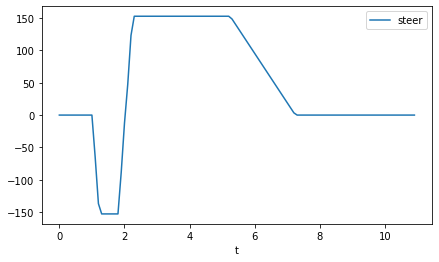

In [12]:
df.plot(x='t', y='steer', figsize=(7,4))

create driver input dataframe from PC Crash input data

In [13]:
end_time = df.t.max()
t = np.arange(0, end_time + 0.1, 0.1).tolist()
throttle = [0] * len(t)                      
brake = [0] * len(t)              
steer = list(df.steer)
driver_input_dict = {'t':t, 'throttle':throttle, 'brake':brake, 'steer':steer}
driver_input_df = pd.DataFrame.from_dict(driver_input_dict)

#### Assign validation data to `veh2`

In [14]:
veh2 = Vehicle('Veh2', vehicle_input_dict)
veh2.driver_input = driver_input_df
# apply validation data as a model result
veh2.model = df

Vehicle inputs for Veh2 applied succesfully


#### vehicle:
- "Vehicle" stores information about a single vehicle - all possible inputs do not need to be entered
- creating a Vehicle requires a "name" which is used to identify the vehicle in outputs / plots etc.


#### Create Pycrash vehicle
- set initial velocity
- try varying cg height - `hcg`
- you will get a `UserWarning` but it's fine

In [18]:
veh1 = Vehicle('Veh1', vehicle_input_dict)
veh1.time_inputs(t, throttle, brake, steer)
veh1.vx_initial = 35
# CG height of 1 foot performed best under most conditions
veh1.hcg = 1   # set CG height

Vehicle inputs for Veh1 applied succesfully
Driver inputs applied to Veh1


### Create Single Motion Instance
- simulation is run when instance is created which takes a few seconds
- model is generating data at each time step as well as all position data to draw vehicle position

In [19]:
simulation_name = '35 mph fishhook'
print(f'Creating Simulation: {simulation_name}')
run = SingleMotion(simulation_name, veh1)

Creating Simulation: 35 mph fishhook
Maximum allowable friction: 0.76
Time step for vehicle motion (s) : 0.01
Maximum tire slip angle (deg): 10.00
Driver input for Veh1 of shape = (1091, 4)
Vehicle motion will be simulated for 10.9 seconds


In [ ]:
cg_motion(run.veh.model, df, 'Pycrash', 'PC-Crash')

### Plot Kinematic Data

In [ ]:
run.plot_model()

### Plot Vehicle Motion

In [ ]:
i = len(run.veh.model) - 1 # draw motion at end of simulation
print(f"Time: {run.veh.model.t[i]}")
run.global_motion(i)

In [ ]:
plot_motion_interval(run.veh, num_itter = 15)

### Compare to PC Crash Model

In [ ]:
# calculate vehicle slip angle for pycrash model - need to correct
phi_rad = []
phi_deg = []
for i in range(len(run.veh.model.t)):
    phi_rad.append(math.atan2(run.veh.model.vy[i], run.veh.model.vx[i])) 
    phi_deg.append(math.atan2(run.veh.model.vy[i], run.veh.model.vx[i])*(180 / math.pi))
    
run.veh.model['phi_rad'] = phi_rad
run.veh.model['phi_deg'] = phi_deg

In [ ]:
compare_kinematics(run.veh.model, df, 'Pycrash', 'PC-Crash')

### Get position data for validation vehicle

### Tire Details
- Pycrash model only

In [ ]:
tire_details(run.veh)

In [ ]:
vertical_forces(run.veh)

### Compare Vehicle Positions

In [ ]:
disp_pycrash = run.veh.model[['t', 'Dx', 'Dy']].copy()
disp_pycrash.rename(columns={'Dx':'Dx_pycrash', 'Dy':'Dy_pycrash'}, inplace=True)
disp_pccrash = df[['t', 'Dx', 'Dy']].copy()
disp_pccrash.rename(columns={'Dx':'Dx_pccrash', 'Dy':'Dy_pccrash'}, inplace=True)
disp_compare = pd.merge(disp_pccrash, disp_pycrash, how = 'left', on = 't')
disp_compare.head()

In [ ]:
dx_pycrash = disp_compare.Dx_pycrash.to_list()
dy_pycrash = disp_compare.Dy_pycrash.to_list()
dx_pccrash = disp_compare.Dx_pccrash.to_list()
dy_pccrash = disp_compare.Dy_pccrash.to_list()
time = disp_compare.t.to_list()
dx_diff = [(x - y)**2 for (x,y) in zip(dx_pycrash, dx_pccrash)]
dy_diff = [(x - y)**2 for (x,y) in zip(dy_pycrash, dy_pccrash)]
c_sqrd = [np.sqrt(x + y) for (x,y) in zip(dx_diff, dy_diff)]

In [ ]:
c_sqrd_1g = c_sqrd.copy()

In [ ]:
c_sqrd_2 = c_sqrd.copy()
c_sqrd_half = c_sqrd.copy()

In [ ]:
max(c_sqrd_1g)

In [ ]:
c_sqrd_half[65]

In [ ]:
c_sqrd_2[65]

In [ ]:
print(f"Maximum resultant distance between the CG: {max(c_sqrd):0.2} feet")

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time, c_sqrd_2, c='black', linewidth=2.0)
plt.plot(time, c_sqrd_half, c='blue', linewidth=2.0)
plt.plot(time, c_sqrd_1g, c='green', linewidth=2.0)
plt.xlabel("Simulation Time (s)", fontsize=16)
plt.ylabel("Resultant Difference (feet)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
x_diff_plot = [dx_pycrash[-1], dx_pccrash[-1]]
y_diff_plot = [dy_pycrash[-1], dy_pccrash[-1]]

In [ ]:
colors = ['green', 'black']
plt.scatter(x_diff_plot, y_diff_plot, c=colors)
plt.show()